# Argo float profile collection for KS3 challenge

### Load required packages

In [1]:
import xarray as xr
import numpy as np
import random
import os

### Download NetCDF datafile from online archive

In [2]:
# uncomment to download a fresh copy
#os.system('wget -q https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EE3C40/DQBDDA -O argo_data.nc');

### Open dataset using xarray, drop data variables that aren't needed

In [3]:
# open the Argo dataset as an xarray Dataset
ds = xr.open_dataset('argo_data.nc', decode_times=False)

# drop the variables that aren't needed
ds = ds.drop({'prof_descr',
              'prof_date',
              'prof_Tweight',
              'prof_Sweight',
              'prof_TeccoV4R2',
              'prof_SeccoV4R2',
              'prof_TeccoV4R2clim',
              'prof_SeccoV4R2clim'})

# display the contents of the dataset
ds

<xarray.Dataset>
Dimensions:     (iDEPTH: 55, iPROF: 246450)
Dimensions without coordinates: iDEPTH, iPROF
Data variables:
    prof_depth  (iDEPTH) float64 ...
    prof_lon    (iPROF) float64 ...
    prof_lat    (iPROF) float64 ...
    prof_T      (iPROF, iDEPTH) float64 ...
    prof_S      (iPROF, iDEPTH) float64 ...
Attributes:
    Format:       The contents of this MITprof file were processed \nusing th...
    date:         02-Apr-2016
    Conventions:  CF-1.6
    title:        Observed and estimated profiles
    institution:  MIT
    references:   Forget, G., J.-M. Campin, P. Heimbach, C. N. Hill, R. M. Po...
    history:      2016/03/22 -- formatting for online publication -- GF

### Plot latitude range

(array([ 7911., 36327., 38645., 33268., 30442., 37586., 35925., 19210.,
         6317.,   819.]),
 array([-74.60668792, -58.18211913, -41.75755034, -25.33298155,
         -8.90841275,   7.51615604,  23.94072483,  40.36529362,
         56.78986242,  73.21443121,  89.639     ]),
 <BarContainer object of 10 artists>)

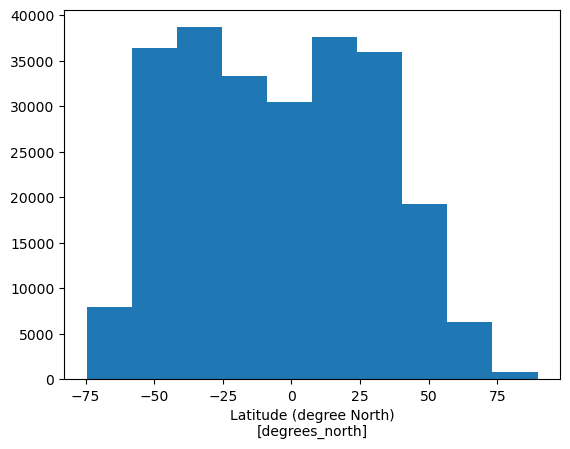

In [4]:
ds.prof_lat.plot.hist()

### Plot example temperature profile 

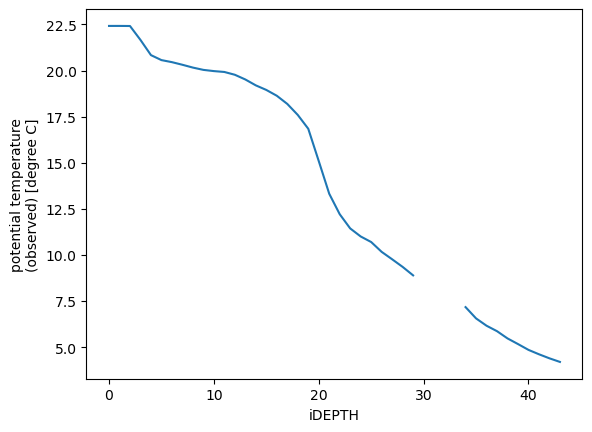

In [5]:
ds.sel(iPROF=5086).prof_T.plot()

### Plot example salinity profile

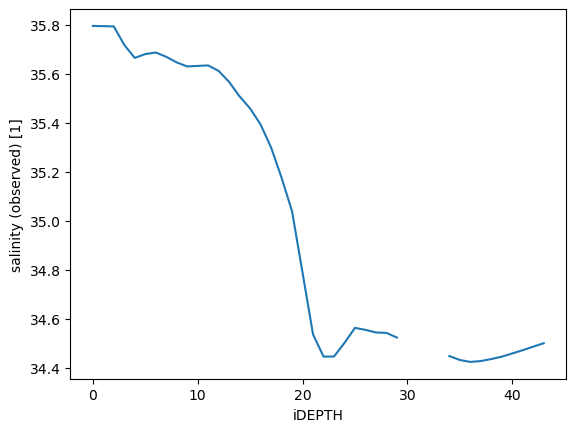

In [6]:
ds.sel(iPROF=5086).prof_S.plot()

### Select depth(s)

In [7]:
# approx. 5m, 100m, 500m, and 1000m depth
#ds = ds.sel(iDEPTH=[0,10,34,44])

# just at 5m for simplicity
ds = ds.sel(iDEPTH=0)

### Select profiles from each region, drop profiles with NaNs, and select random subsample

In [8]:
# polar
in_latrange_polar = (ds.prof_lat > 60) | (ds.prof_lat < -60)
polar = ds.where(in_latrange_polar, drop=True).dropna(dim='iPROF', how='any')
polar = polar.isel(iPROF=sorted(random.sample(range(0,polar.iPROF.size-1),150)))
polar['region'] = 'polar'

# subtropical
in_latrange_subtropical = (ds.prof_lat > 23) & (ds.prof_lat <= 60)
subtropical = ds.where(in_latrange_subtropical, drop=True).dropna(dim='iPROF', how='any')
subtropical = subtropical.isel(iPROF=sorted(random.sample(range(0,subtropical.iPROF.size-1),150)))
subtropical['region'] = 'subtropical'

# tropical
in_latrange_tropical = (ds.prof_lat >= 0) & (ds.prof_lat <= 23)
tropical = ds.where(in_latrange_tropical).dropna(dim='iPROF', how='any')
tropical = tropical.isel(iPROF=sorted(random.sample(range(0,tropical.iPROF.size-1),150)))
tropical['region'] = 'tropical'

### Combine three labelled Datasets together 

In [9]:
# combined separate labeled Datasets into one single Dataset
profile_dataset = xr.combine_nested([polar,subtropical,tropical], concat_dim='iPROF')

# drop the locations and depths (simulated lat/lon data corruption/malfunction)
profile_dataset = profile_dataset.drop({'prof_lon','prof_lat','prof_depth'})

# rename some variables for better interpretability
profile_dataset = profile_dataset.rename({'iPROF'     : 'profile',
                                          'prof_T'    : 'temperature',
                                          'prof_S'    : 'salinity'})

# display contents of dataset
profile_dataset

<xarray.Dataset>
Dimensions:      (profile: 450)
Dimensions without coordinates: profile
Data variables:
    temperature  (profile) float64 -1.155 -1.571 -0.3329 ... 25.34 26.66 26.19
    salinity     (profile) float64 33.35 33.92 33.64 33.7 ... 34.09 34.43 34.1
    region       (profile) <U11 'polar' 'polar' ... 'tropical' 'tropical'

### Examine the mean temperature values for each region

In [10]:
profile_dataset.groupby("region").mean(dim='profile').temperature

<xarray.DataArray 'temperature' (region: 3)>
array([ 2.13171459, 17.57935603, 27.58260712])
Coordinates:
  * region   (region) object 'polar' 'subtropical' 'tropical'

### Examine the mean salinity values for each region

In [11]:
profile_dataset.groupby("region").mean(dim='profile').salinity

<xarray.DataArray 'salinity' (region: 3)>
array([34.04963606, 34.39697558, 34.72116512])
Coordinates:
  * region   (region) object 'polar' 'subtropical' 'tropical'

### Convert Dataset to dataframe for export

In [12]:
df = profile_dataset.to_dataframe()

# randomly shuffle the rows (random appearance)
df = df.sample(frac=1)

# reset index
df = df.reset_index(drop=True)

# round values to two places
df['temperature'] = df['temperature'].round(decimals = 4)
df['salinity'] = df['salinity'].round(decimals = 4)

# display dataframe
df

,temperature,salinity,region
0,5.0481,32.6070,subtropical
1,0.4268,33.4280,polar
2,8.1175,32.9170,subtropical
3,28.3821,35.0890,tropical
4,24.9101,35.2068,subtropical
...,...,...,...
445,28.9983,35.0215,tropical
446,4.6572,34.8490,polar
447,3.2717,33.8150,polar
448,25.7619,34.0792,tropical


### Write out labelled dataset to CSV

In [13]:
df.to_csv('ocean_measurements.csv', index=False)